# Advanced Data Manipulation

Chapter 10 in Python for Data Analysis demonstrates a variety of methods to analyze data via data aggregation and grouping operations. Those are the focus of this session.  Our overall goal for this session is to do Exploratory Data Analysis, which is essentially looking at and probing our data to learn about the patterns we can discover in them.  Often this can generate a better understanding of problems in the data, as well as revealing relationships that might be worth exploring in more depth.

We will cover:

* **Groupby and aggregation functions**
* **Transform operations with groupby**
* **Pivot tables and crosstabs**
* **Correlations**
* **Quantile and bucket analysis**

It is a lot to cover, but these are the core tools to do advanced data analyisis work with Python -- so well worth the effort to learn these thoroughly.

We will use Census Summary File 1 data for much of this session to illustrate concepts using real data.

Below we load a table I created previously with an extract of data from the 2010 Census, Summary File 1, for the Bay Area.  The file is being loaded from an HDF5 datastore - this and other file formats are covered in Chapter 6 of Python for Data Analysis.

In [1]:
import pandas as pd

sf1store = pd.HDFStore('data/bay_sf1_small.h5')
sf1 = sf1store['sf1_extract']
sf1['pct_rent'] = sf1['H0040004'] / sf1['H0040001'] * 100
sf1['pct_black'] = sf1['P0030003'] / sf1['P0030001'] * 100
sf1['pct_asian'] = sf1['P0030005'] / sf1['P0030001'] * 100
sf1['pct_white'] = sf1['P0030002'] / sf1['P0030001'] * 100
sf1['pct_hisp'] = sf1['P0040003'] / sf1['P0040001'] * 100
sf1['pct_vacant'] = sf1['H0050001'] / sf1['H00010001'] * 100
sf1['pop_sqmi'] = (sf1['P0010001'] / (sf1['arealand'] / 2589988))
sf1 = sf1[sf1['P0030001']>0]
sf1[:5]

,logrecno,blockfips,state,county,tract,blkgrp,block,arealand,P0010001,P0020001,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
1,26,060014271001001,06,001,427100,1,1001,79696,113,113,...,0,0,0,80.000000,13.274336,5.309735,78.761062,1.769912,0.000000,3672.312839
3,28,060014271001003,06,001,427100,1,1003,19546,29,29,...,0,0,2,70.000000,13.793103,27.586207,37.931034,24.137931,23.076923,3842.712166
4,29,060014271001004,06,001,427100,1,1004,14364,26,26,...,0,0,0,75.000000,0.000000,38.461538,34.615385,0.000000,0.000000,4688.087441
6,31,060014271001006,06,001,427100,1,1006,1281,2,2,...,0,0,0,100.000000,0.000000,50.000000,0.000000,100.000000,0.000000,4043.697112
7,32,060014271001007,06,001,427100,1,1007,19020,30,30,...,0,0,0,33.333333,0.000000,43.333333,50.000000,0.000000,10.000000,4085.154574


How many blocks are there in the Bay Area?

In [31]:
len(sf1)

68797

In [33]:
sf1.shape

(68797, 50)

What counties do we have in the data?

In [14]:
sf1.county.unique()

array(['001', '013', '041', '055', '075', '081', '085', '095', '097'], dtype=object)

## Groupby and Aggregation Operations

Groupby is a powerful method in pandas that follows the split-apply-combine approach to data.  As shown in Figure 9-1 in the context of a sum operation, the data is first split into groups that share the same key values.  Then an operation, in this case a sum, is applied to each group.  Then the results are combined.

The built-in aggregation methods available for groupby operations include:
* count
* sum
* mean
* median
* std, var
* min, max
* first, last

You can also apply your own functions as aggregation methods.

<img src='img/groupby.png' height="800" width="500">

Let's apply this approach to computing total population in each county in our dataset.  We can do this in two steps to help explain what is happening.  First we create a groupby object, using county codes to group all the census blocks in sf1 into groups that share the same county code.

In [2]:
grouped = sf1['P0010001'].groupby(sf1['county'])
grouped

Now that we have this grouping object that represents the **split** part of the workflow in the figure above, we can **apply** operations and **combine** the results using methods like sum:

In [3]:
grouped.sum()

county
001    1510271
013    1049025
041     252409
055     136484
075     805235
081     718451
085    1781642
095     413344
097     483878
Name: P0010001, dtype: int64

Doing this in two steps like above is really just to clarify the two parts of the split and apply process that happen within a groupy operation.  Normally we would not bother separately creating a groupby object -- we would just do this in one line:

In [4]:
sf1['P0010001'].groupby(sf1['county']).sum()

county
001    1510271
013    1049025
041     252409
055     136484
075     805235
081     718451
085    1781642
095     413344
097     483878
Name: P0010001, dtype: int64

Let's add county names to the dataframe so we get more readable output, and rerun this aggregation.

In [6]:
county_names = {'001': 'Alameda', '013': 'Contra Costa', '041': 'Marin', '055': 'Napa', '075': 'San Francisco',
                '081': 'San Mateo', '085': 'Santa Clara', '095': 'Solano', '097': 'Sonoma'}

Let's add county_name as a column in the dataframe.  It would be easy to append it as the last column with a merge, but let's see how to insert it in a specified location so that it is easier to read when we browse the data.  We can insert it as the 4th column, between county and tract, like so:

In [7]:
sf1.insert(4, 'county_name', sf1['county'].replace(county_names))
sf1[:5]

,logrecno,blockfips,state,county,county_name,tract,blkgrp,block,arealand,P0010001,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
1,26,060014271001001,06,001,Alameda,427100,1,1001,79696,113,...,0,0,0,80.000000,13.274336,5.309735,78.761062,1.769912,0.000000,3672.312839
3,28,060014271001003,06,001,Alameda,427100,1,1003,19546,29,...,0,0,2,70.000000,13.793103,27.586207,37.931034,24.137931,23.076923,3842.712166
4,29,060014271001004,06,001,Alameda,427100,1,1004,14364,26,...,0,0,0,75.000000,0.000000,38.461538,34.615385,0.000000,0.000000,4688.087441
6,31,060014271001006,06,001,Alameda,427100,1,1006,1281,2,...,0,0,0,100.000000,0.000000,50.000000,0.000000,100.000000,0.000000,4043.697112
7,32,060014271001007,06,001,Alameda,427100,1,1007,19020,30,...,0,0,0,33.333333,0.000000,43.333333,50.000000,0.000000,10.000000,4085.154574


Now we can print the results of summing population by county_name:

In [8]:
print('Total Population by County:')
print(sf1['P0010001'].groupby(sf1['county_name']).sum())

Total Population by County:
county_name
Alameda          1510271
Contra Costa     1049025
Marin             252409
Napa              136484
San Francisco     805235
San Mateo         718451
Santa Clara      1781642
Solano            413344
Sonoma            483878
Name: P0010001, dtype: int64


We might want to capture the result in a DataFrame if we want to use it in other processing, like merging the results to the original DataFrame.

In [9]:
county_pop = sf1['P0010001'].groupby(sf1['county_name']).sum().to_frame(name='total_population').reset_index()
county_pop

,county_name,total_population
0,Alameda,1510271
1,Contra Costa,1049025
2,Marin,252409
3,Napa,136484
4,San Francisco,805235
5,San Mateo,718451
6,Santa Clara,1781642
7,Solano,413344
8,Sonoma,483878


Here we merge the county total population with sf1 and create a new DataFrame.

In [10]:
sf2 = pd.merge(sf1,county_pop, left_index=True, right_index=True)
sf2.shape

(5, 52)

Let's say we wanted to compute the population per square mile by county using the groupby method.  We could go ahead and create another dataframe with total area by county than then do the division of total population by total area.

In [11]:
county_land = sf1['arealand'].groupby(sf1['county_name']).sum().to_frame(name='total_area').reset_index()
county_land

,county_name,total_area
0,Alameda,1190434861
1,Contra Costa,1095085515
2,Marin,1046029032
3,Napa,1556005658
4,San Francisco,95535946
5,San Mateo,884654868
6,Santa Clara,2378681334
7,Solano,1224964331
8,Sonoma,3206326062


In [12]:
county_pop_per_sqmi = county_pop['total_population'] / county_land['total_area'] * 2589988.11
county_pop_per_sqmi

0     3285.844577
1     2481.050329
2      624.969565
3      227.179082
4    21829.993454
5     2103.396042
6     1939.911635
7      873.948750
8      390.864261
dtype: float64

Or of course we could have done this whole thing in one line:

In [13]:
sf1['P0010001'].groupby(sf1['county_name']).sum() / sf1['arealand'].groupby(sf1['county_name']).sum() * 2589988.11

county_name
Alameda           3285.844577
Contra Costa      2481.050329
Marin              624.969565
Napa               227.179082
San Francisco    21829.993454
San Mateo         2103.396042
Santa Clara       1939.911635
Solano             873.948750
Sonoma             390.864261
dtype: float64

You can specify the aggregation functions you want explicitly, and include several in a list:

In [19]:
sf1['P0010001'].groupby(sf1['county_name']).agg(['min','max','mean'])

,min,max,mean
county_name,,,
Alameda,1,4324,107.248331
Contra Costa,1,1933,92.416968
Marin,1,4854,88.347567
Napa,1,1410,75.032435
San Francisco,1,3169,156.751995
San Mateo,1,2223,104.486766
Santa Clara,1,3142,119.197297
Solano,1,5115,79.673092
Sonoma,1,1617,73.987462


You can even specify specific quantiles to compute for each group.

In [22]:
sf1['P0010001'].groupby(sf1['county_name']).quantile(.99)

county_name
Alameda          712.38
Contra Costa     643.50
Marin            646.88
Napa             570.86
San Francisco    724.28
San Mateo        662.25
Santa Clara      791.62
Solano           547.91
Sonoma           550.61
Name: P0010001, dtype: float64

## Your turn to practice:

Count the number of census blocks per county.

Calculate total households per county.

Calculate percent renters by county. (Careful not to calculate the mean percent rental across blocks in a county)

Calculate percent vacant by county.

Calculate mean, min and max pop_sqmi (at the block level) by county.

Calculate the 90th percentile of pop_sqmi (at the block level) by county.

## Transforming Data with Groupby

In some cases you may want to apply a function to your data, by group.  An example would be to normalize a column by a mean of each group.  Say we wanted to subtract the mean population density of each county from the population density of each census block. We could write a function to subtract the mean from each value, and then use the transform operation to apply this to each group:

In [23]:
def demean(arr):
    return arr - arr.mean()

Now we can apply this tranformation to columns in our dataframe.  As examples, let's 'demean' the pop_sqmi and pct_rent columns, subtracting the county-wide mean of these values from the block-specific values, so that the result is transformed to have a mean of zero within each county.

To check the results, we print the means per county, then the original values for the first 5 rows, then the transformed results.  The transformed results we should be able to calculate by subtracting the appropriate county mean from the block value.

In [25]:
print('Means by County')
print(sf1[['pop_sqmi', 'pct_rent']].groupby(sf1['county_name']).mean())

Means by County
                   pop_sqmi   pct_rent
county_name                           
Alameda        13753.632044  37.484398
Contra Costa    8081.846244  27.223329
Marin           6338.936151  33.169454
Napa            6245.985021  32.903209
San Francisco  28395.093537  51.927943
San Mateo      11011.638488  30.274104
Santa Clara    10598.597545  29.811290
Solano          7203.793038  34.598761
Sonoma          5415.876988  35.121698


In [26]:
print('Original Values of 1st 5 Rows')
print(sf1[['county_name','pop_sqmi', 'pct_rent']][:5])

Original Values of 1st 5 Rows
  county_name     pop_sqmi    pct_rent
1     Alameda  3672.312839   80.000000
3     Alameda  3842.712166   70.000000
4     Alameda  4688.087441   75.000000
6     Alameda  4043.697112  100.000000
7     Alameda  4085.154574   33.333333


Now create the normalized version, subtracting the county means from each row

In [28]:
normalized = sf1[['pop_sqmi', 'pct_rent']].groupby(sf1['county_name']).transform(demean)

In [29]:
print(normalized[:5])

       pop_sqmi   pct_rent
1 -10081.319205  42.515602
3  -9910.919878  32.515602
4  -9065.544603  37.515602
6  -9709.934932  62.515602
7  -9668.477470  -4.151064


We can merge these transformed results on to the original DataFrame, and check the means of the original variables and the tranformed ones.  The transformed ones should be arbitrarily close to zero.

In [30]:
sf2 = pd.merge(sf1,normalized, left_index=True, right_index=True)

sf2.groupby('county_name')[['pop_sqmi_x', 'pop_sqmi_y', 'pct_rent_x', 'pct_rent_y']].mean()

,pop_sqmi_x,pop_sqmi_y,pct_rent_x,pct_rent_y
county_name,,,,
Alameda,13753.632044,-7.944529e-11,37.484398,6.856168e-14
Contra Costa,8081.846244,-7.040712e-12,27.223329,-3.800049e-13
Marin,6338.936151,1.461176e-12,33.169454,9.143583e-15
Napa,6245.985021,-1.304992e-13,32.903209,-1.685373e-14
San Francisco,28395.093537,6.833338e-12,51.927943,-1.349699e-15
San Mateo,11011.638488,8.192330e-12,30.274104,-7.197617e-14
Santa Clara,10598.597545,5.347880e-11,29.811290,-1.211290e-13
Solano,7203.793038,9.815285e-12,34.598761,-5.029091e-14
Sonoma,5415.876988,1.308518e-11,35.121698,-5.937600e-14


Apply is a method we have learned previously, which allows us to apply a function to each row in a DataFrame.  We can also combine apply with groupby to apply functions based on group membership.  For example, the function 'top' sorts an array and selects the top n rows from it.  We provide some defaults for the arguments of how many rows, and the column to use for the selection:

In [34]:
def top(df, n=5, column='pop_sqmi'):
    return df.sort_values(by=column, ascending=False).head(n)

Using this on the full dataset and setting the number of rows and the column to get the top values for, in this case using pct_rent to override the default argument, we get the top 10 blocks in the region in terms of percentage rental.

In [35]:
top(sf1, n=10, column='pct_rent')

,logrecno,blockfips,state,county,county_name,tract,blkgrp,block,arealand,P0010001,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
55399,593009,060750352022006,06,075,San Francisco,035202,2,2006,5420,38,...,0,0,0,100.0,0.000000,18.421053,68.421053,2.631579,7.142857,18158.587454
55283,592876,060750332043011,06,075,San Francisco,033204,3,3011,19179,160,...,0,0,0,100.0,10.000000,18.125000,50.625000,23.750000,10.000000,21606.865843
55270,592862,060750332042000,06,075,San Francisco,033204,2,2000,3140,7,...,0,0,0,100.0,0.000000,100.000000,0.000000,0.000000,0.000000,5773.858599
55271,592863,060750332042001,06,075,San Francisco,033204,2,2001,70847,1480,...,2,0,2,100.0,6.824324,34.054054,47.567568,12.364865,8.064516,54105.074880
55273,592866,060750332043001,06,075,San Francisco,033204,3,3001,46198,41,...,0,0,0,100.0,9.756098,14.634146,48.780488,19.512195,6.250000,2298.573704
55277,592870,060750332043005,06,075,San Francisco,033204,3,3005,15537,85,...,0,0,0,100.0,9.411765,30.588235,44.705882,14.117647,30.769231,14169.336423
55278,592871,060750332043006,06,075,San Francisco,033204,3,3006,2013,2,...,0,0,0,100.0,0.000000,0.000000,100.000000,0.000000,0.000000,2573.261798
55279,592872,060750332043007,06,075,San Francisco,033204,3,3007,22700,697,...,2,0,3,100.0,4.304161,42.467719,39.885222,13.199426,12.745098,79525.182203
55280,592873,060750332043008,06,075,San Francisco,033204,3,3008,21981,211,...,1,0,1,100.0,5.213270,26.540284,47.867299,19.431280,8.000000,24861.811019
55281,592874,060750332043009,06,075,San Francisco,033204,3,3009,15863,137,...,0,0,0,100.0,6.569343,29.927007,48.175182,17.518248,12.121212,22368.300826


Below we apply this with groupby and use the defaults for n and column, and it applies the function within each county and concatenates the results, producing the top 5 blocks on pop_sqmi for each county in the region.

In [36]:
sf1.groupby('county_name').apply(top)

logrecno        blockfips state county    county_name  \
county_name                                                                   
Alameda       8494        9073  060014311002003    06    001        Alameda   
              4786        5117  060014419251004    06    001        Alameda   
              19003      20241  060014028002013    06    001        Alameda   
              9130        9766  060014351042022    06    001        Alameda   
              9702       10388  060014369001004    06    001        Alameda   
Contra Costa  37338      56116  060133551151034    06    013   Contra Costa   
              27063      45017  060133150001190    06    013   Contra Costa   
              25628      43440  060133131021012    06    013   Contra Costa   
              27062      45016  060133150001170    06    013   Contra Costa   
              27904      45921  060133340042011    06    013   Contra Costa   
Marin         46754     316228  060411302021012    06    041          Marin   
              46762     316236  060411302021020    06    041          Marin   
              46748     316222  060411302021006    06    041          Marin   
              44846     314094  060411220001000    06    041          Marin   
              45030     314297  060411060013037    06    041          Marin   
Napa          47380     355511  060552010032003    06    055           Napa   
              47402     355533  060552010032026    06    055           Napa   
              48190     356373  060552005051002    06    055           Napa   
              48904     357165  060552003013027    06    055           Napa   
              48388     356588  060552007043003    06    055           Napa   
San Francisco 55230     592818  060750332031009    06    075  San Francisco   
              50114     587161  060750125011003    06    075  San Francisco   
              56373     594081  060750611002003    06    075  San Francisco   
              49731     586709  060750105002008    06    075  San Francisco   
              50073     587114  060750124012001    06    075  San Francisco   
San Mateo     60283     625772  060816102021046    06    081      San Mateo   
              60573     626075  060816103042020    06    081      San Mateo   
              60370     625862  060816102032006    06    081      San Mateo   
              63541     629335  060816016011005    06    081      San Mateo   
              63840     629667  060816008003006    06    081      San Mateo   
Santa Clara   68422     646761  060855080013002    06    085    Santa Clara   
              72470     651175  060855113011005    06    085    Santa Clara   
              73117     651856  060855002002002    06    085    Santa Clara   
              75335     654276  060855031084002    06    085    Santa Clara   
              73520     652286  060855009022000    06    085    Santa Clara   
Solano        90767     701757  060952524014012    06    095         Solano   
              90347     701314  060952523122011    06    095         Solano   
              97423     708802  060952509001009    06    095         Solano   
              90421     701392  060952523133040    06    095         Solano   
              91166     702183  060952526081007    06    095         Solano   
Sonoma        106920    719441  060971514023013    06    097         Sonoma   
              106731    719231  060971533001020    06    097         Sonoma   
              104931    717285  060971516023063    06    097         Sonoma   
              104670    717002  060971514025003    06    097         Sonoma   
              106928    719450  060971514024003    06    097         Sonoma   

                       tract  blkgrp block  arealand  P0010001      ...       \
county_name                                                         ...        
Alameda       8494    431100       2  2003       320       392      ...        
              4786    441925       1  1004      1240       801      

Here we pass arguments to the function to set n and the column to select the top value from.

In [37]:
sf1.groupby('county_name').apply(top, n=1, column='arealand')

,,logrecno,blockfips,state,county,county_name,tract,blkgrp,block,arealand,P0010001,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
county_name,,,,,,,,,,,,,,,,,,,,,,
Alameda,12544,13434,060014301021000,06,001,Alameda,430102,1,1000,31296322,166,...,0,0,3,45.283019,1.204819,3.614458,84.337349,6.024096,7.017544,13.737653
Contra Costa,37789,56579,060133551121158,06,013,Contra Costa,355112,1,1158,19441925,141,...,2,0,3,23.809524,2.127660,0.709220,75.886525,24.822695,12.500000,18.783547
Marin,42773,311828,060411322003008,06,041,Marin,132200,3,3008,48884156,112,...,14,6,0,91.666667,0.000000,0.892857,64.285714,66.071429,36.842105,5.934002
Napa,47066,355191,060552018001000,06,055,Napa,201800,1,1000,93228090,13,...,4,1,2,83.333333,0.000000,0.000000,92.307692,0.000000,53.846154,0.361156
San Francisco,56139,593833,060750604001013,06,075,San Francisco,060400,1,1013,1036262,3,...,0,0,0,NaN,0.000000,33.333333,66.666667,0.000000,NaN,7.498069
San Mateo,57660,622919,060816138001035,06,081,San Mateo,613800,1,1035,28976148,105,...,0,0,4,55.172414,0.952381,0.000000,47.619048,60.952381,19.444444,9.385262
Santa Clara,66451,644610,060855135001202,06,085,Santa Clara,513500,1,1202,277483160,62,...,3,0,1,16.666667,3.225806,0.000000,82.258065,1.612903,14.285714,0.578699
Solano,92499,703629,060952527026009,06,095,Solano,252702,6,6009,30318073,14,...,1,0,0,33.333333,0.000000,35.714286,64.285714,0.000000,14.285714,1.195981
Sonoma,99632,711527,060971542022000,06,097,Sonoma,154202,2,2000,35658559,106,...,14,0,1,36.585366,0.000000,0.000000,89.622642,14.150943,28.070175,7.699098


## Experimenting with Rental Listings Merged with SF1

Let's read the geocoded rental listings for the Bay Area to begin.  We will make sure the fips_block column is read as a string dtype so we can merge properly with the census data.  It has leading zeros and is a string in the census data.

In [38]:
rentals = pd.read_csv('data/sfbay_geocoded.csv', usecols=['rent', 'bedrooms', 'sqft', 'fips_block', 'longitude', 'latitude'], dtype={'fips_block': str})
#rentals = pd.read_csv('sfbay_geocoded.csv')
                                                    
rentals[:5]

,rent,bedrooms,sqft,longitude,latitude,fips_block
0,4500.0,2.0,1200.0,-122.438300,37.745000,060750216002015
1,2650.0,2.0,1040.0,-122.008131,37.353699,060855085053008
2,3100.0,2.0,1000.0,-122.439743,37.731584,060750311005011
3,1850.0,1.0,792.0,-122.234294,37.491715,060816101001026
4,1325.0,1.0,642.0,-122.087751,37.923448,060133400021004


And merge it with the census data using the FIPS block codes, which are named differently in the two DataFrames.

In [39]:
rentals_sf1 = pd.merge(rentals, sf1, left_on='fips_block', right_on='blockfips')
rentals_sf1[:10]

,rent,bedrooms,sqft,longitude,latitude,fips_block,logrecno,blockfips,state,county,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
0,4500.0,2.0,1200.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
1,6250.0,3.0,1215.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
2,6250.0,3.0,1215.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
3,6650.0,3.0,2900.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
4,2600.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
5,2615.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
6,2615.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
7,2600.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
8,3200.0,NaN,900.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
9,2600.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053


Now we can begin looking at this merged dataset.  Let's start by computing mean rents by county.

In [40]:
county_rents = rentals_sf1.groupby(rentals_sf1['county_name'])[['rent']].mean().sort_values(by='rent', ascending=False)
county_rents

,rent
county_name,
San Francisco,3746.737974
Marin,3277.287562
San Mateo,2857.011248
Santa Clara,2665.584276
Alameda,2235.584293
Napa,2117.797398
Contra Costa,1955.075348
Sonoma,1805.140760
Solano,1359.965551


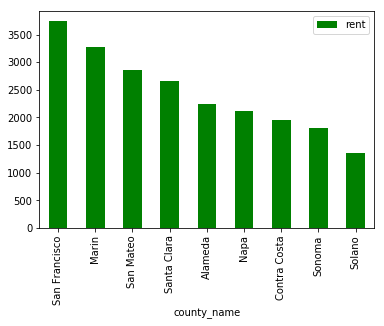

In [41]:
%matplotlib inline

county_rents.plot(kind='bar', color='g')

Those patterns generally conform to our expectations, with San Francisco highest and Solano lowest.

Let's examine these patterns by county and number of bedrooms. We can just use two columns in the groupby to do this.

In [42]:
rentals_sf1.groupby(['county_name', 'bedrooms'])[['rent']].mean()

rent
county_name   bedrooms             
Alameda       1.0       1862.396037
              2.0       2284.538409
              3.0       2715.874074
              4.0       3315.346895
              5.0       4820.488152
              6.0       5898.392857
              7.0       7362.500000
              8.0       8400.000000
Contra Costa  1.0       1596.991079
              2.0       1874.641106
              3.0       2390.508197
              4.0       2831.713831
              5.0       3547.841808
              6.0       3258.636364
              7.0       7172.500000
              8.0       3200.000000
Marin         1.0       2209.910211
              2.0       2998.448575
              3.0       4476.835979
              4.0       5837.602273
              5.0       5145.666667
              6.0       5250.000000
Napa          1.0       1387.362745
              2.0       1846.914110
              3.0       2447.333333
              4.0       2998.593750
              5.0       3009.000000
San Francisco 1.0       3099.179065
              2.0       4225.756604
              3.0       5151.170096
...                             ...
              5.0       7525.666667
              6.0       7750.000000
              7.0       9950.000000
              8.0       9900.000000
San Mateo     1.0       2266.792148
              2.0       2975.375058
              3.0       3888.506952
              4.0       5292.336683
              5.0       5633.618182
              6.0       7260.000000
Santa Clara   1.0       2143.095373
              2.0       2721.721386
              3.0       3451.772947
              4.0       4280.278307
              5.0       5642.350211
              6.0       6704.545455
              7.0       6028.571429
              8.0       2550.000000
Solano        1.0       1143.470514
              2.0       1277.712283
              3.0       1640.565678
              4.0       2043.212766
              5.0       2491.250000
              7.0       3000.000000
Sonoma        1.0       1403.868078
              2.0       1830.113469
              3.0       2284.307937
              4.0       2738.465347
              5.0       3037.500000
              6.0       3295.000000

[61 rows x 1 columns]

That output is a bit too long, since there are rows for many bedroom counts (and few units have > 6 bedrooms!).  Let's trim this by looking only at units with less than 4 bedrooms.

In [43]:
rentals_sf1[rentals_sf1['bedrooms']<4].groupby(['county_name', 'bedrooms'])[['rent']].mean()

rent
county_name   bedrooms             
Alameda       1.0       1862.396037
              2.0       2284.538409
              3.0       2715.874074
Contra Costa  1.0       1596.991079
              2.0       1874.641106
              3.0       2390.508197
Marin         1.0       2209.910211
              2.0       2998.448575
              3.0       4476.835979
Napa          1.0       1387.362745
              2.0       1846.914110
              3.0       2447.333333
San Francisco 1.0       3099.179065
              2.0       4225.756604
              3.0       5151.170096
San Mateo     1.0       2266.792148
              2.0       2975.375058
              3.0       3888.506952
Santa Clara   1.0       2143.095373
              2.0       2721.721386
              3.0       3451.772947
Solano        1.0       1143.470514
              2.0       1277.712283
              3.0       1640.565678
Sonoma        1.0       1403.868078
              2.0       1830.113469
              3.0       2284.307937

## Pivot tables and crosstabs

Notice that we have a hierarchical index (county, then bedrooms within county).  We can use unstack on this to make it easier to work with for the bar charts, or even to look at as a table:

In [35]:
rentals_sf1[rentals_sf1['bedrooms']<4].groupby(['county_name', 'bedrooms'])[['rent']].mean().unstack()

rent                          
bedrooms               1.0          2.0          3.0
county_name                                         
Alameda        1862.396037  2284.538409  2715.874074
Contra Costa   1596.991079  1874.641106  2390.508197
Marin          2209.910211  2998.448575  4476.835979
Napa           1387.362745  1846.914110  2447.333333
San Francisco  3099.179065  4225.756604  5151.170096
San Mateo      2266.792148  2975.375058  3888.506952
Santa Clara    2143.095373  2721.721386  3451.772947
Solano         1143.470514  1277.712283  1640.565678
Sonoma         1403.868078  1830.113469  2284.307937

Pandas also provides a syntax for doing this that is familiar for spreadsheet users: the pivot_table.  You can see below that using pivot_table achieves exactly the same result.  

In [37]:
pd.pivot_table(rentals_sf1[rentals_sf1['bedrooms']<4], values='rent', index=['county_name'], columns=['bedrooms'])

bedrooms,1.0,2.0,3.0
county_name,,,
Alameda,1862.396037,2284.538409,2715.874074
Contra Costa,1596.991079,1874.641106,2390.508197
Marin,2209.910211,2998.448575,4476.835979
Napa,1387.362745,1846.914110,2447.333333
San Francisco,3099.179065,4225.756604,5151.170096
San Mateo,2266.792148,2975.375058,3888.506952
Santa Clara,2143.095373,2721.721386,3451.772947
Solano,1143.470514,1277.712283,1640.565678
Sonoma,1403.868078,1830.113469,2284.307937


In addition to providing a convenience interface to groupby, pivot_table also can add partial totals, or margins.

In [44]:
pd.pivot_table(rentals_sf1[rentals_sf1['bedrooms']<4], values='rent', index=['county_name'], columns=['bedrooms'], margins=True)

bedrooms,1.0,2.0,3.0,All
county_name,,,,
Alameda,1862.396037,2284.538409,2715.874074,2161.681932
Contra Costa,1596.991079,1874.641106,2390.508197,1856.947814
Marin,2209.910211,2998.448575,4476.835979,3061.734740
Napa,1387.362745,1846.914110,2447.333333,1999.539130
San Francisco,3099.179065,4225.756604,5151.170096,3861.692972
San Mateo,2266.792148,2975.375058,3888.506952,2801.402538
Santa Clara,2143.095373,2721.721386,3451.772947,2590.512772
Solano,1143.470514,1277.712283,1640.565678,1300.941814
Sonoma,1403.868078,1830.113469,2284.307937,1775.032962


Although mean is the default type of aggregation in pivot_table, you can use other methods like len, to get a frequency crosstab with the count of observations in each cell of the table, as well as the margins.  Let's remove the filter on number of bedrooms to see the full frequency distribution.

In [45]:
pd.pivot_table(rentals_sf1, values='rent', index=['county_name'], columns=['bedrooms'], aggfunc=len, margins=True)

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
county_name,,,,,,,,,
Alameda,4290.0,4361.0,1350.0,467.0,211.0,28.0,4.0,1.0,10712.0
Contra Costa,2242.0,3508.0,976.0,629.0,177.0,33.0,4.0,1.0,7570.0
Marin,568.0,807.0,378.0,176.0,15.0,2.0,NaN,NaN,1946.0
Napa,102.0,163.0,195.0,64.0,5.0,NaN,NaN,NaN,529.0
San Francisco,2245.0,2120.0,729.0,207.0,15.0,4.0,1.0,1.0,5322.0
San Mateo,2598.0,2141.0,935.0,199.0,55.0,5.0,NaN,NaN,5933.0
Santa Clara,7413.0,8973.0,2484.0,945.0,237.0,11.0,7.0,1.0,20071.0
Solano,797.0,1498.0,472.0,188.0,32.0,NaN,10.0,NaN,2997.0
Sonoma,614.0,1225.0,315.0,101.0,4.0,1.0,NaN,NaN,2260.0


A simpler way to generate a crosstabulation is also built in to pandas: the crosstab method.

In [46]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True)

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
county_name,,,,,,,,,
Alameda,4290,4361,1350,467,211,28,4,1,10712
Contra Costa,2242,3508,976,629,177,33,4,1,7570
Marin,568,807,378,176,15,2,0,0,1946
Napa,102,163,195,64,5,0,0,0,529
San Francisco,2245,2120,729,207,15,4,1,1,5322
San Mateo,2598,2141,935,199,55,5,0,0,5933
Santa Clara,7413,8973,2484,945,237,11,7,1,20071
Solano,797,1498,472,188,32,0,10,0,2997
Sonoma,614,1225,315,101,4,1,0,0,2260


Besides the simpler syntax, the other advantage of crosstab for doing this is that you can normalize the crosstab, dividing all the cell values by the grand total.  This tells us the fraction of the region's total listings that are in each combination of county and number of bedrooms.

In [47]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True, normalize=True)

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
county_name,,,,,,,,,
Alameda,0.074817,0.076055,0.023544,0.008144,0.003680,0.000488,0.000070,0.000017,0.186815
Contra Costa,0.039100,0.061179,0.017021,0.010970,0.003087,0.000576,0.000070,0.000017,0.132020
Marin,0.009906,0.014074,0.006592,0.003069,0.000262,0.000035,0.000000,0.000000,0.033938
Napa,0.001779,0.002843,0.003401,0.001116,0.000087,0.000000,0.000000,0.000000,0.009226
San Francisco,0.039152,0.036972,0.012714,0.003610,0.000262,0.000070,0.000017,0.000017,0.092815
San Mateo,0.045309,0.037339,0.016306,0.003471,0.000959,0.000087,0.000000,0.000000,0.103471
Santa Clara,0.129281,0.156488,0.043321,0.016481,0.004133,0.000192,0.000122,0.000017,0.350035
Solano,0.013900,0.026125,0.008232,0.003279,0.000558,0.000000,0.000174,0.000000,0.052267
Sonoma,0.010708,0.021364,0.005494,0.001761,0.000070,0.000017,0.000000,0.000000,0.039414


We have the option to normalize on the index, which is the county_name in this case, so we see the fraction of the county listings that are of each number of bedrooms.  The rows sum to 1.

In [48]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True, normalize='index')

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
county_name,,,,,,,,
Alameda,0.400485,0.407114,0.126027,0.043596,0.019698,0.002614,0.000373,0.000093
Contra Costa,0.296169,0.463408,0.128930,0.083091,0.023382,0.004359,0.000528,0.000132
Marin,0.291881,0.414697,0.194245,0.090442,0.007708,0.001028,0.000000,0.000000
Napa,0.192817,0.308129,0.368620,0.120983,0.009452,0.000000,0.000000,0.000000
San Francisco,0.421834,0.398346,0.136979,0.038895,0.002818,0.000752,0.000188,0.000188
San Mateo,0.437890,0.360863,0.157593,0.033541,0.009270,0.000843,0.000000,0.000000
Santa Clara,0.369339,0.447063,0.123761,0.047083,0.011808,0.000548,0.000349,0.000050
Solano,0.265933,0.499833,0.157491,0.062729,0.010677,0.000000,0.003337,0.000000
Sonoma,0.271681,0.542035,0.139381,0.044690,0.001770,0.000442,0.000000,0.000000


The counterpart is to normalize by column, in which case we see the fraction of 1 bedroom listings in the region that are in each county, and so on for different bedroom counts.


In [49]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True, normalize='columns')

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
county_name,,,,,,,,,
Alameda,0.205568,0.175875,0.172326,0.156922,0.280959,0.333333,0.153846,0.25,0.186815
Contra Costa,0.107432,0.141474,0.124585,0.211358,0.235686,0.392857,0.153846,0.25,0.132020
Marin,0.027217,0.032546,0.048251,0.059140,0.019973,0.023810,0.000000,0.00,0.033938
Napa,0.004888,0.006574,0.024891,0.021505,0.006658,0.000000,0.000000,0.00,0.009226
San Francisco,0.107576,0.085498,0.093056,0.069556,0.019973,0.047619,0.038462,0.25,0.092815
San Mateo,0.124491,0.086345,0.119352,0.066868,0.073236,0.059524,0.000000,0.00,0.103471
Santa Clara,0.355216,0.361873,0.317079,0.317540,0.315579,0.130952,0.269231,0.25,0.350035
Solano,0.038191,0.060413,0.060250,0.063172,0.042610,0.000000,0.384615,0.00,0.052267
Sonoma,0.029422,0.049403,0.040209,0.033938,0.005326,0.011905,0.000000,0.00,0.039414


What if we want to look at more statistics than just mean? We can combine several aggregation methods and compute them at one time.

In [50]:
rentals_sf1[rentals_sf1['bedrooms']<4].groupby(['county_name', 'bedrooms'])[['rent']].agg(['mean', 'std', 'min', 'max'])

rent                              
                               mean          std     min      max
county_name   bedrooms                                           
Alameda       1.0       1862.396037   393.300923   500.0   4950.0
              2.0       2284.538409   534.999766   800.0   4998.0
              3.0       2715.874074   806.606556   350.0   7500.0
Contra Costa  1.0       1596.991079   375.069796   496.0   3125.0
              2.0       1874.641106   505.719679   689.0   3895.0
              3.0       2390.508197   775.568225   793.0   5995.0
Marin         1.0       2209.910211   618.305211   430.0   5600.0
              2.0       2998.448575   950.448793  1325.0   9500.0
              3.0       4476.835979  1423.768448  1657.0   9000.0
Napa          1.0       1387.362745   224.556583   750.0   1800.0
              2.0       1846.914110   500.127260   850.0   4050.0
              3.0       2447.333333   997.897308  1250.0   9775.0
San Francisco 1.0       3099.179065   720.636564   725.0   7500.0
              2.0       4225.756604  1284.521670   750.0   9800.0
              3.0       5151.170096  1738.374226  1600.0  10250.0
San Mateo     1.0       2266.792148   411.746679   880.0   5000.0
              2.0       2975.375058   612.783070   832.0   6500.0
              3.0       3888.506952  1192.532121  1800.0  10000.0
Santa Clara   1.0       2143.095373   451.835127   550.0   5202.0
              2.0       2721.721386   664.622785   900.0   9065.0
              3.0       3451.772947  1013.365050   650.0   9999.0
Solano        1.0       1143.470514   214.261987   590.0   1849.0
              2.0       1277.712283   238.327602   799.0   2300.0
              3.0       1640.565678   408.047945   950.0   4500.0
Sonoma        1.0       1403.868078   280.041020   550.0   3200.0
              2.0       1830.113469   363.751789   995.0   4500.0
              3.0       2284.307937   545.081841  1200.0   5000.0

Remember the 'top' function we defined earlier? We can use it here to get the top rental listing in each county, for each bedroom size.

In [51]:
rentals_sf1.groupby(['county_name', 'bedrooms']).apply(top, n=1, column='rent')

rent  bedrooms    sqft   longitude  \
county_name   bedrooms                                                
Alameda       1.0      29483   4950.0       1.0   800.0 -122.280400   
              2.0      36889   4998.0       2.0  1400.0 -122.264292   
              3.0      58544   7500.0       3.0  2500.0 -122.226934   
              4.0      43448   8200.0       4.0  3247.0 -122.229400   
              5.0      22134   7800.0       5.0  1856.0 -122.266723   
              6.0      45415  10200.0       6.0  2600.0 -122.255180   
              7.0      44877   9200.0       7.0  2600.0 -122.250000   
              8.0      59696   8400.0       8.0  3000.0 -122.266181   
Contra Costa  1.0      27811   3125.0       1.0   539.0 -122.073700   
              2.0      21614   3895.0       2.0  1050.0 -122.128766   
              3.0      48922   5995.0       3.0  2800.0 -122.103853   
              4.0      47943   8900.0       4.0  2014.0 -122.294780   
              5.0      55529   8500.0       5.0  5000.0 -121.933726   
              6.0      42145   6400.0       6.0  4667.0 -122.024503   
              7.0      21197   8630.0       7.0  5000.0 -122.298500   
              8.0      45048   3200.0       8.0  4400.0 -121.862755   
Marin         1.0      40634   5600.0       1.0   850.0 -122.580085   
              2.0      46206   9500.0       2.0  2000.0 -122.453098   
              3.0      58235   9000.0       3.0  3000.0 -122.533016   
              4.0      55933  10000.0       4.0  3000.0 -122.491484   
              5.0      36041   8000.0       5.0  2965.0 -122.547233   
              6.0      54010   5500.0       6.0  4500.0 -122.612793   
Napa          1.0      60137   1800.0       1.0   600.0 -122.290361   
              2.0      11868   4050.0       2.0  1200.0 -122.473290   
              3.0      56172   9775.0       3.0  4000.0 -122.445300   
              4.0      59306   7500.0       4.0  3500.0 -122.143250   
              5.0      60288   3950.0       5.0  4000.0 -122.242298   
San Francisco 1.0      53478   7500.0       1.0  1526.0 -122.395813   
              2.0      16350   9800.0       2.0  1900.0 -122.409100   
              3.0      48749  10250.0       3.0  3598.0 -122.448787   
...                               ...       ...     ...         ...   
              5.0      37111  10000.0       5.0  2700.0 -122.449183   
              6.0      56555   9850.0       6.0  1654.0 -122.417557   
              7.0      56553   9950.0       7.0  1894.0 -122.417727   
              8.0      49849   9900.0       8.0  2500.0 -122.453516   
San Mateo     1.0      50707   5000.0       1.0  1050.0 -122.220976   
              2.0      45175   6500.0       2.0  1660.0 -122.192476   
              3.0      34850  10000.0       3.0  2800.0 -122.186400   
              4.0      34871  10000.0       4.0  3200.0 -122.186400   
              5.0      34855  10000.0       5.0  3000.0 -122.186400   
              6.0      54429   9500.0       6.0  3195.0 -122.192152   
Santa Clara   1.0      8833    5202.0       1.0   792.0 -122.016435   
              2.0      1228    9065.0       2.0  2750.0 -121.935600   
              3.0      59425   9999.0       3.0  2267.0 -122.137241   
              4.0      50057  10000.0       4.0  2700.0 -122.105673   
              5.0      59076  10000.0       5.0  2500.0 -122.141243   
              6.0      26178  10000.0       6.0  3485.0 -122.134174   
              7.0      845     9900.0       7.0  2000.0 -122.146875   
              8.0      31771   2550.0       8.0   774.0 -122.003174   
Solano        1.0      22728   1849.0       1.0   862.0 -122.149733   
              2.0      57504   2300.0       2.0  1000.0 -122.215571   
              3.0      33286   4500.0       3.0  2300.0 -122.186894   
              4.0      60319   3495.0       4.0  3050.0 -122.154064   
              5.0      50440   4000.0       5.0  4088.0 -122.159041   
              7.0      38787   3200.0       7.0  2518.0 -

## Exploring Correlations in the Data

Pandas provides simple ways of computing correlation coefficients among the columns in your DataFrame.  If you use corr() on a full DF, it will produce a large correlation table.  A bit hard to navigate and you mostly would not be interested in some of these results.

In [52]:
rentals_sf1.corr()

,rent,bedrooms,sqft,longitude,latitude,logrecno,blkgrp,arealand,P0010001,P0020001,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
rent,1.000000,0.481234,0.616653,-0.189488,-0.208624,0.185653,-0.011133,-0.002037,-0.116857,-0.116857,...,0.087468,-0.015596,0.010655,-0.137076,-0.222322,0.073785,0.191424,-0.290056,0.030535,0.020475
bedrooms,0.481234,1.000000,0.819533,0.035085,0.065029,-0.039371,0.028106,0.051052,-0.120218,-0.120218,...,-0.078880,-0.014990,-0.034599,-0.330290,-0.000024,-0.014917,0.040864,-0.035118,-0.049176,-0.125802
sqft,0.616653,0.819533,1.000000,0.009677,0.041737,-0.016225,0.008702,0.075221,-0.113589,-0.113589,...,-0.044212,-0.009650,-0.031854,-0.331541,-0.045550,-0.010680,0.090546,-0.105976,-0.018599,-0.132978
longitude,-0.189488,0.035085,0.009677,1.000000,-0.548065,-0.130319,-0.098020,-0.043462,0.094442,0.094442,...,-0.109002,0.030678,-0.099010,-0.067935,-0.023140,0.235135,-0.284017,0.156813,-0.135010,-0.072233
latitude,-0.208624,0.065029,0.041737,-0.548065,1.000000,-0.306019,0.069752,0.080858,-0.105149,-0.105149,...,0.033156,0.010343,0.072333,-0.013489,0.265711,-0.407035,0.253876,-0.003537,0.123641,-0.011506
logrecno,0.185653,-0.039371,-0.016225,-0.130319,-0.306019,1.000000,0.050819,-0.011586,0.020363,0.020363,...,0.022854,-0.029056,-0.085817,0.069324,-0.245896,0.140300,-0.032165,0.055755,-0.018806,0.069862
blkgrp,-0.011133,0.028106,0.008702,-0.098020,0.069752,0.050819,1.000000,-0.001086,-0.018809,-0.018809,...,0.041022,-0.009702,-0.023974,0.015964,-0.039342,0.005227,0.018223,-0.009363,0.032782,0.030694
arealand,-0.002037,0.051052,0.075221,-0.043462,0.080858,-0.011586,-0.001086,1.000000,0.069781,0.069781,...,0.079438,0.011564,0.030822,-0.084488,-0.038112,-0.063535,0.094328,-0.026265,0.022772,-0.087006
P0010001,-0.116857,-0.120218,-0.113589,0.094442,-0.105149,0.020363,-0.018809,0.069781,1.000000,1.000000,...,0.188282,0.086167,0.175744,0.278962,0.018317,0.203882,-0.231680,0.056364,0.008534,0.206183
P0020001,-0.116857,-0.120218,-0.113589,0.094442,-0.105149,0.020363,-0.018809,0.069781,1.000000,1.000000,...,0.188282,0.086167,0.175744,0.278962,0.018317,0.203882,-0.231680,0.056364,0.008534,0.206183


It is easy to compute correlation coeffients for a subset of columns.

In [53]:
rentals_sf1[['rent', 'sqft']].corr()

,rent,sqft
rent,1.000000,0.616653
sqft,0.616653,1.000000


And this method can be combined with groupby to compute correlation tables by group.

In [54]:
rentals_sf1.groupby('county_name')[['rent', 'sqft']].corr()

rent      sqft
county_name                           
Alameda       rent  1.000000  0.784616
              sqft  0.784616  1.000000
Contra Costa  rent  1.000000  0.688621
              sqft  0.688621  1.000000
Marin         rent  1.000000  0.799108
              sqft  0.799108  1.000000
Napa          rent  1.000000  0.711565
              sqft  0.711565  1.000000
San Francisco rent  1.000000  0.740660
              sqft  0.740660  1.000000
San Mateo     rent  1.000000  0.816791
              sqft  0.816791  1.000000
Santa Clara   rent  1.000000  0.771930
              sqft  0.771930  1.000000
Solano        rent  1.000000  0.816569
              sqft  0.816569  1.000000
Sonoma        rent  1.000000  0.823559
              sqft  0.823559  1.000000

In [55]:
rentals_sf1[rentals_sf1['bedrooms']<4].groupby('bedrooms')[['rent', 'sqft']].corr()

rent      sqft
bedrooms                         
1.0      rent  1.000000  0.350723
         sqft  0.350723  1.000000
2.0      rent  1.000000  0.485617
         sqft  0.485617  1.000000
3.0      rent  1.000000  0.445744
         sqft  0.445744  1.000000

## Quantile and Bucket Analysis

We use below the cut method to create categories for ranges of a variable.  In this example we use 4 even intevals using cut.  If we used qcut instead, it would generate quantiles for us.

In [56]:
factor = pd.cut(rentals_sf1['sqft'], 4)
factor[:5]

0    (216.064, 1455.0]
1    (216.064, 1455.0]
2    (216.064, 1455.0]
3     (2689.0, 3923.0]
4    (216.064, 1455.0]
Name: sqft, dtype: category
Categories (4, interval[float64]): [(216.064, 1455.0] < (1455.0, 2689.0] < (2689.0, 3923.0] < (3923.0, 5157.0]]

Define a function to get grouped statistics.

In [57]:
def get_stats(group):
    return{'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

Apply the function to the DataFrame for a specified column.

In [58]:
grouped = rentals_sf1['rent'].groupby(factor)
grouped.apply(get_stats).unstack()

,count,max,mean,min
sqft,,,,
"(216.064, 1455.0]",53054.0,8500.0,2317.507521,350.0
"(1455.0, 2689.0]",7003.0,10200.0,3742.959732,295.0
"(2689.0, 3923.0]",983.0,10250.0,5334.371312,750.0
"(3923.0, 5157.0]",163.0,10000.0,5913.877301,1300.0


## Your turn to experiment

Try practicing these techniques on your own, to do the following:

* Calculate the mean sqft of rental listings by county
* Calculate the standard deviation (std) of sqft of rental listings by county and bedroom
* Compute correlation coefficients among rent, sqft, pct_white, pct_black, pct_asian and pct_hisp, by county and for the region
* Redo the statistical profile on rents by categories of sqft range using 10 quantiles rather than 4 equal bins
